In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import os
import time
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg

In [2]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64 
FEATURES_GEN = 64 
beta = 0.5


Device: cuda


In [3]:
if not os.path.exists('generated_image'):
   os.makedirs('generated_image')

In [4]:
dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=4)

Files already downloaded and verified


/home/hasan2/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),      #out=128,k=5,s=2,p=1
            self._block(features_d * 2, features_d * 4, 4, 2, 1),  #out=256,k=5,s=2,p=1
            self._block(features_d * 4, features_d * 8, 4, 2, 1),  #out=512,k=5,s=2,p=1
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            #nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [6]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            #Gnet(in_channels, out_channels, kernel_size, stride, padding)
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [7]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [8]:
#Intitating instances
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [9]:
optimGenerator = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(beta, 0.999))
optimDiscriminator = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(beta, 0.999))
criterion = nn.BCELoss()
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)   #usally is Batch_SIZE, NOISE.., but for DCGAN 32 works better!!
step = 0

In [10]:
gen.train(),disc.train()

(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): C

In [11]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

/home/hasan2/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hasan2/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [13]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [14]:
def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [15]:
#training block
GenLoss = []
DiscLoss = []
img_list = []
FID_list = []
iters = 0

print("!!Training Started!!")
# start timing
time_start = time.time() 
for epoch in range(NUM_EPOCHS):
    epoch = epoch+1
    
#     for batch_idx, (real, _) in enumerate(dataloader):

    for batch_idx, data in enumerate(dataloader,0):
        #training with real batch
        real = data[0].to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise) #genrator img data

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        optimDiscriminator.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_disc.detach().cpu())
        
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    
    #Cal. FID
    fretchet_dist=calculate_fretchet(real,fake,model)
    FID_list.append(fretchet_dist)
    
    #if epoch%5 == 0:
    print( f'\nEpoch [{epoch}/{NUM_EPOCHS}]Batch {batch_idx}/{len(dataloader)} \
                  Loss Discriminator: {loss_disc:.3f}, loss Generator: {loss_gen:.3f} FID:{fretchet_dist:.3f} ') #,end = '\r', flush=True)
    
    #Saving Generated image/epoch     
    images = gen(fixed_noise)
    if not os.path.exists('generated_image/DCGAN_FAKE'):
       os.makedirs('generated_image/DCGAN_FAKE')
    if not os.path.exists('generated_image/DCGAN_REAL'):
       os.makedirs('generated_image/DCGAN_REAL')
    utils.save_image(images.detach(),'generated_image/DCGAN_FAKE/DCGAN50_epoch_%03d.png' % (epoch), normalize = True)
    
    #Saving Real image/epoch 
#     real = data[0].to(device)
    utils.save_image(real.detach(),'generated_image/DCGAN_REAL/DCGAN50_epoch_%03d.png' % (epoch), normalize = True)
        
    
time_end = time.time()
print('\n\n elapsed time：%.2f s.'%(time_end-time_start))

!!Training Started!!

Epoch [1/40]Batch 781/782                   Loss Discriminator: 0.309, loss Generator: 1.517 FID:499.452 

Epoch [2/40]Batch 781/782                   Loss Discriminator: 0.331, loss Generator: 1.790 FID:433.398 

Epoch [3/40]Batch 781/782                   Loss Discriminator: 0.559, loss Generator: 1.011 FID:441.820 

Epoch [4/40]Batch 781/782                   Loss Discriminator: 0.554, loss Generator: 0.871 FID:340.649 

Epoch [5/40]Batch 781/782                   Loss Discriminator: 0.607, loss Generator: 0.921 FID:313.914 

Epoch [6/40]Batch 781/782                   Loss Discriminator: 0.600, loss Generator: 0.772 FID:371.502 

Epoch [7/40]Batch 781/782                   Loss Discriminator: 0.677, loss Generator: 0.899 FID:347.549 

Epoch [8/40]Batch 781/782                   Loss Discriminator: 0.627, loss Generator: 0.909 FID:324.824 

Epoch [9/40]Batch 781/782                   Loss Discriminator: 0.634, loss Generator: 0.810 FID:296.703 

Epoch [10/40]Ba

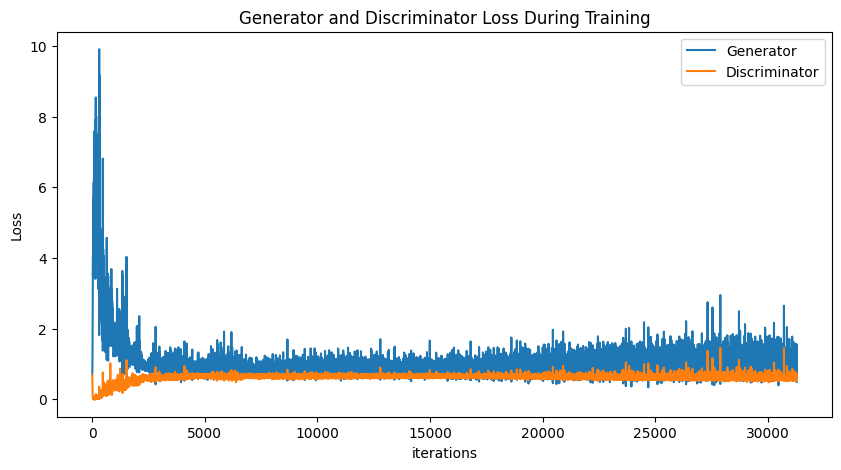

In [16]:
if not os.path.exists('generated_image/Loss_Data'):
       os.makedirs('generated_image/Loss_Data')
np.save('generated_image/Loss_Data/DCGAN_GLoss', GenLoss) 
np.save('generated_image/Loss_Data/DCGAN_DLoss', DiscLoss) 
GenLoss = np.load('generated_image/Loss_Data/DCGAN_GLoss.npy')
DiscLoss = np.load('generated_image/Loss_Data/DCGAN_DLoss.npy')
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss,label="Generator")
plt.plot(DiscLoss,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('generated_image/loss.png',
            format='png',
            bbox_inches='tight')
plt.show()

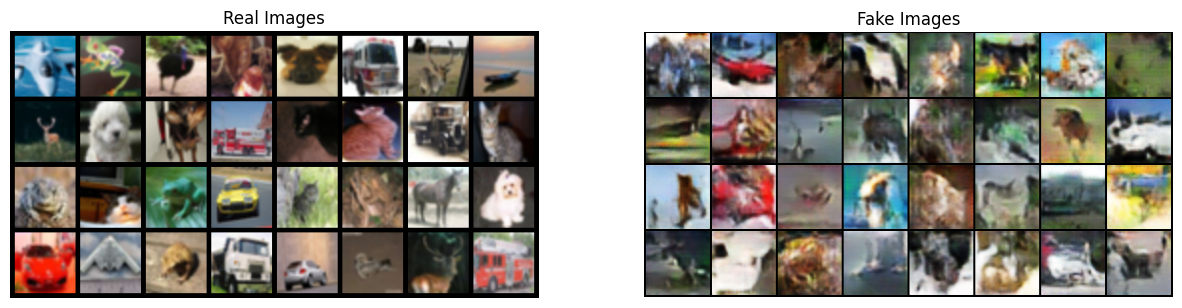

In [17]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('generated_image/DCGAN_BEST_FAKE.pdf',
            format='pdf',
            bbox_inches='tight')
plt.show()

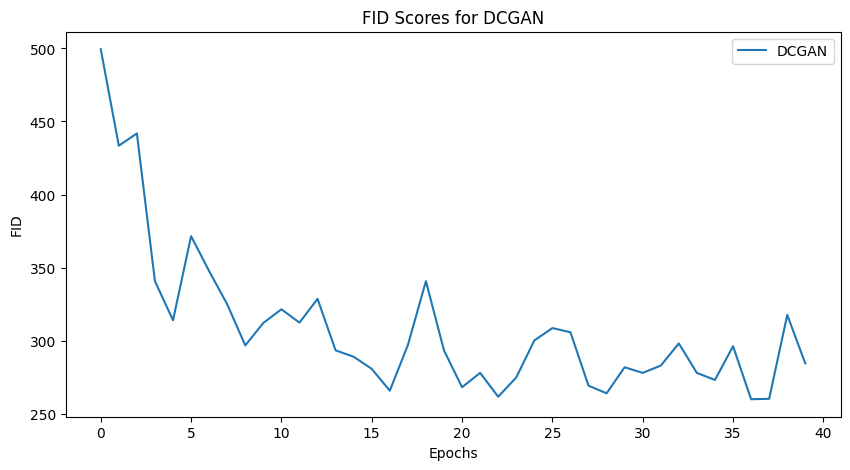

In [18]:
plt.figure(figsize=(10,5))
plt.title("FID Scores for DCGAN")
plt.plot(FID_list,label="DCGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('generated_image/FID.pdf',
            format='pdf',
            bbox_inches='tight')
plt.show()

In [19]:
if not os.path.exists('generated_image/FID_score'):
       os.makedirs('generated_image/FID_score')
np.save('generated_image/FID_score/DC_FID', FID_list) 

In [22]:
np.mean(GenLoss),np.mean(DiscLoss),np.min(GenLoss),np.min(DiscLoss),GenLoss[-1],DiscLoss[-1]

(np.float32(1.0653033),
 np.float32(0.60127115),
 np.float32(0.3353258),
 np.float32(0.0024705476),
 np.float32(0.69364643),
 np.float32(0.66527367))

In [23]:
np.min(FID_list), np.max(FID_list), np.mean(FID_list), FID_list[-1]

(np.float64(218.80396308935144),
 np.float64(462.80419054356616),
 np.float64(281.36402492170413),
 np.float64(256.05553100226615))